In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from scipy import stats

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
msmt_cols = inspector.get_columns('measurement')
for col in msmt_cols:
    print(col['name'], col['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
station_cols = inspector.get_columns('station')
for col in station_cols:
    print(col['name'], col['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
Base.metadata.tables

immutabledict({'measurement': Table('measurement', MetaData(bind=None), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None), 'station': Table('station', MetaData(bind=None), Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<station>), Column('name', TEXT(), table=<station>), Column('latitude', FLOAT(), table=<station>), Column('longitude', FLOAT(), table=<station>), Column('elevation', FLOAT(), table=<station>), schema=None)})

## Precipitation Analysis

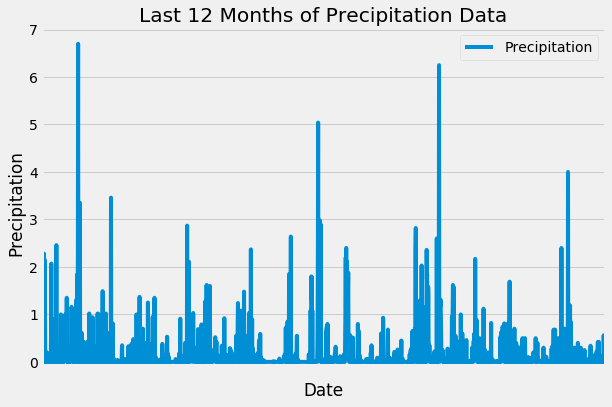

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
msmt_test = session.query(Measurement).order_by(Measurement.date.desc()).first()
last_test = pd.to_datetime(msmt_test.date)
first_test = last_test - timedelta(days=365)
first_date = dt.date(first_test.year, first_test.month, first_test.day)
last_date = dt.date(last_test.year, last_test.month, last_test.day)

# Perform a query to retrieve the data and precipitation scores
msmt_year = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date >= first_date).\
    order_by(Measurement.date.asc()).\
    all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_year_df = pd.DataFrame(msmt_year,columns=['Date','Precipitation'])
precip_year_df = precip_year_df.set_index('Date')
precip_year_df = precip_year_df.fillna(0)

# Sort the dataframe by date
precip_year_df.sort_values(by='Date')
precip_year_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
plt.style.use('fivethirtyeight')
precip_year_df.plot(figsize=(9,6))
plt.xticks([])
plt.legend(['Precipitation'])
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title('Last 12 Months of Precipitation Data')
plt.savefig('Images/prcp12months.png')
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_year_df.describe()

,Precipitation
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


## Station Analysis

In [16]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(Station).count()
print(f'The total number of stations in this dataset is {num_stations}')

The total number of stations in this dataset is 9


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()#.distinct(Station.station).count()#group_by(Station.station).all()
station_count = {station: count for station, count in station_count}
print('Stations and Counts:')
print('--------------------')
for station,count in station_count.items():
    print(station,count)
print('====================')

# station_count
station_list = list(station_count)
top_station = station_list[0]
top_station_count = station_count[top_station]
print(f'The most active station is {top_station} with {top_station_count} counts')

Stations and Counts:
--------------------
USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511
The most active station is USC00519281 with 2772 counts


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
top_station_temps = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == top_station).all()
print(top_station_temps)
top_station_low, top_station_high, top_station_avg = top_station_temps[0]

print(f'\nFor the most active station ({top_station}):')
print(f'Lowest temperature recorded: {top_station_low}')
print(f'Highest temperature recorded: {top_station_high}')
print(f'Average temperature recorded: {top_station_avg}')

[(54.0, 85.0, 71.66378066378067)]

For the most active station (USC00519281):
Lowest temperature recorded: 54.0
Highest temperature recorded: 85.0
Average temperature recorded: 71.66378066378067


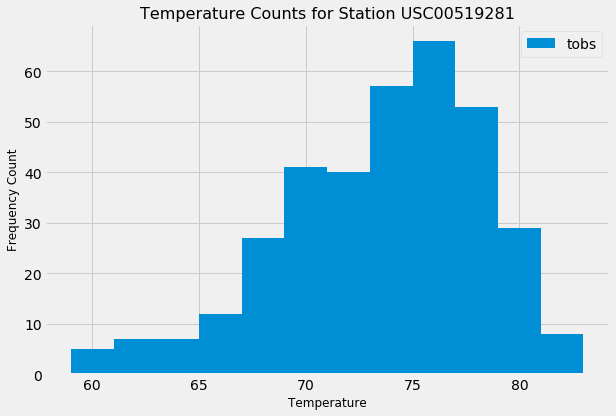

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_year = session.query(Measurement.date,Measurement.tobs).filter(Measurement.date >= first_date).filter(Measurement.date <= last_date).filter(Measurement.station == top_station).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
temp_year_df = pd.DataFrame(temp_year,columns=['Date','TOBS'])
temp_year_df = temp_year_df.set_index('Date')

# Sort the dataframe by date
temp_year_df.sort_values(by='Date')
temp_year_df.head()

#Plot the results as a histogram with bins=12
plt.figure(figsize=(9,6))
plt.hist(temp_year_df['TOBS'].values,bins=12)
plt.legend(['tobs'],loc='best')
plt.ylabel('Frequency Count',size=12)
plt.xlabel('Temperature',size=12)
plt.title(f'Temperature Counts for Station {top_station}',size=16)
plt.savefig('Images/tobsCountHistogram.png')
plt.show()

### Temperature Analysis I
- Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?


- You may either use SQLAlchemy or pandas's read_csv() to perform this portion.


- Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.


- Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

In [20]:
def avg_month_temp(month):
    '''
        Function that returns the yearly average temperatures across all stations given a month, either June or December
        Prints out the year and the average temperature for the respective year
        
        Inputs: month -- the month that you want the yearly average temperatures
                    -- either June or December
    
        Outputs: 1. a list of average temperatures per year of the month given
                2. a list of the years available in the dataset
                
    '''
    years = np.arange(2010,2017,1)
    avg_temps_june = []
    avg_temps_dec = []
    if month.lower() == 'june':
        for year in years:
            june_start_noYEAR = '06-01'
            june_end_noYEAR = '06-30'
            june_start = f'{year}-{june_start_noYEAR}'
            june_end = f'{year}-{june_end_noYEAR}'
            june_df = avg_tobs_df[(avg_tobs_df.index.values>=june_start) & (avg_tobs_df.index.values<=june_end)]
            avg_temp = june_df['tobs'].values.mean()
            print(f'The average temperature in June {year} is {round(avg_temp,4)} F')
            avg_temps_june.append(avg_temp)
        return avg_temps_june, years
    elif month.lower() == 'december':
        for year in years:
            dec_start_noYEAR = '12-01'
            dec_end_noYEAR = '12-31'
            dec_start = f'{year}-{dec_start_noYEAR}'
            dec_end = f'{year}-{dec_start_noYEAR}'
            dec_df = avg_tobs_df[(avg_tobs_df.index.values>=dec_start) & (avg_tobs_df.index.values<=dec_end)]
            avg_temp = dec_df['tobs'].values.mean()
            print(f'The average temperature in December {year} is {round(avg_temp,4)} F')
            avg_temps_dec.append(avg_temp)
        return avg_temps_dec, years
    else:
        print('ERROR: Please enter a valid month')
        

In [21]:
# Read in the csv file and create a DataFrame
csv_df = pd.read_csv('Resources/hawaii_measurements.csv')
avg_tobs_df = csv_df.groupby('date').mean()

# Call the avg_month_temp function to calculate and print the average temperature in June and December at all stations across all available years in the dataset
june_avg = avg_month_temp('june')
print('------------------------------------------------------')
dec_avg = avg_month_temp('december')

The average temperature in June 2010 is 74.9908 F
The average temperature in June 2011 is 73.9024 F
The average temperature in June 2012 is 74.0888 F
The average temperature in June 2013 is 74.6405 F
The average temperature in June 2014 is 75.0717 F
The average temperature in June 2015 is 75.0356 F
The average temperature in June 2016 is 75.1348 F
------------------------------------------------------
The average temperature in December 2010 is 73.125 F
The average temperature in December 2011 is 68.75 F
The average temperature in December 2012 is 70.1667 F
The average temperature in December 2013 is 73.1667 F
The average temperature in December 2014 is 71.625 F
The average temperature in December 2015 is 73.6 F
The average temperature in December 2016 is 73.7143 F


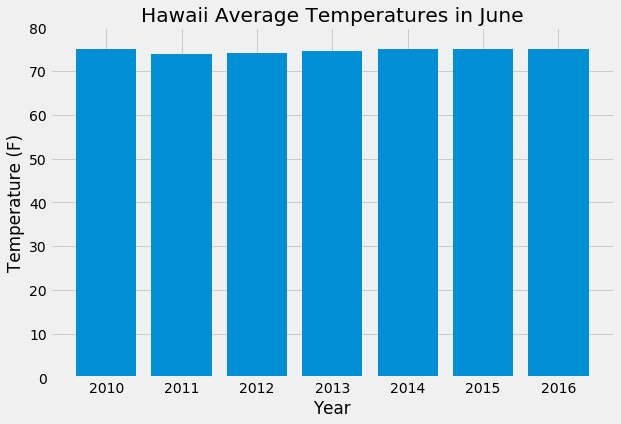

In [22]:
# Plot the average temperatures in June across all years in the dataset
june_df = pd.DataFrame(zip(june_avg[1],june_avg[0]),columns=['Year','Avg Temp'])
june_df = june_df.set_index('Year')
plt.figure(figsize=(9,6))
plt.bar(june_df.index.values,june_df['Avg Temp'])
plt.ylabel('Temperature (F)')
plt.xlabel('Year')
plt.title('Hawaii Average Temperatures in June')
plt.yticks(np.arange(0,90,10))
plt.savefig('Images/avgTobsJune.png')
plt.show()

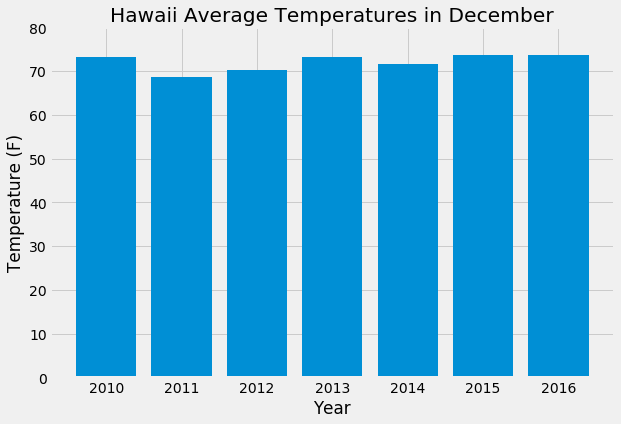

In [23]:
# Plot the average temperature in December at all stations across all available years in the dataset
dec_df = pd.DataFrame(zip(dec_avg[1],dec_avg[0]),columns=['Year','Avg Temp'])
dec_df = dec_df.set_index('Year')
plt.figure(figsize=(9,6))
plt.bar(dec_df.index.values,dec_df['Avg Temp'])
plt.ylabel('Temperature (F)')
plt.xlabel('Year')
plt.title('Hawaii Average Temperatures in December')
plt.yticks(np.arange(0,90,10))
plt.savefig('Images/avgTobsDecember.png')
plt.show()

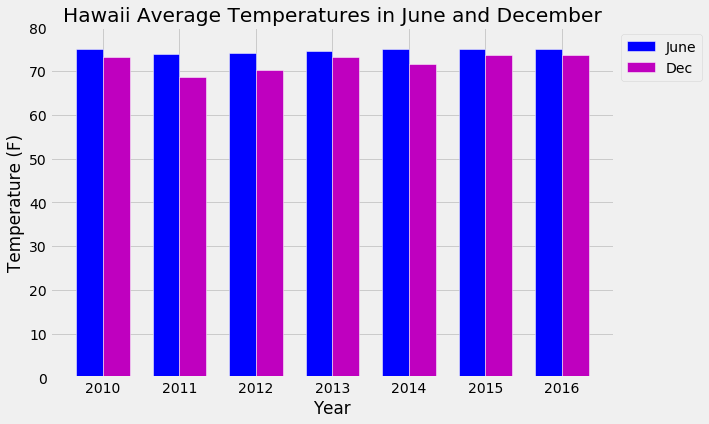

In [24]:
# Plot a grouped bar chart with June and December average temperatures for all years in the dataset
width = 0.35
x= np.arange(0,len(dec_df))
fig,ax = plt.subplots(figsize=(9,6))
rects1 = ax.bar(x-width/2,june_df['Avg Temp'],width,label='June',color='b',edgecolor='w')
rects2 = ax.bar(x+width/2,dec_df['Avg Temp'],width,label='Dec',color='m',edgecolor='w')
ax.set_xticks(x)
ax.set_xticklabels(dec_df.index.values)
ax.set_ylabel('Temperature (F)')
ax.set_xlabel('Year')
ax.set_title('Hawaii Average Temperatures in June and December')
ax.set_yticks(np.arange(0,90,10))
ax.legend(bbox_to_anchor=(1,1))
plt.savefig('Images/avgTobsJuneDec.png')

#### Paired t-test:

##### Hypothesis Test:<br/>
H<sub>0</sub> : u<sub>j</sub> = u<sub>d</sub> (The means are the same)<br/>
H<sub>a</sub> : u<sub>j</sub> != u<sub>d</sub> (The means are different)

Testing at alpha = 0.05

I used paired t-test since the two variables, average tobs in June and average tobs in December, are taken from the same stations, but at different times. Since the average tobs in June can be paired with the average tobs in December, we use a paired t-test. Additionally, there are no obvious outliers in each sample, as shown in the Box Plot below. 

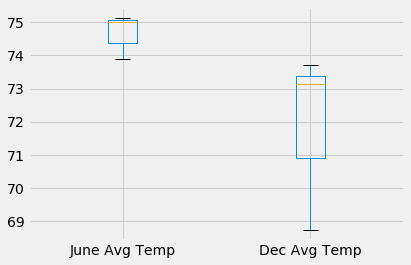

In [25]:
# Combine the june and december data into one DataFrame
june_copy = june_df.copy()
june_copy = june_copy.rename(columns={"Avg Temp" : "June Avg Temp"})
dec_copy = dec_df.copy()
dec_copy = dec_copy.rename(columns={'Avg Temp':'Dec Avg Temp'})
june_dec = pd.concat([june_copy['June Avg Temp'],dec_copy['Dec Avg Temp']],axis=1)

#Check for outliers
june_dec[['June Avg Temp','Dec Avg Temp']].plot(kind='box')

((array([-1.31487275, -0.74397649, -0.3471943 ,  0.        ,  0.3471943 ,
          0.74397649,  1.31487275]),
  array([1.42047619, 1.43563492, 1.47380952, 1.86580688, 3.44670635,
         3.92208995, 5.15244709])),
 (1.548503949786264, 2.673852985638703, 0.9240505002461686))

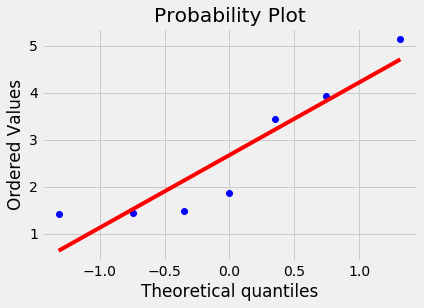

In [26]:
# Test for normality
june_dec['temp_diff'] = june_dec['June Avg Temp']-june_dec['Dec Avg Temp']
stats.probplot(june_dec['temp_diff'], plot= plt)

In [27]:
ttest_results = stats.ttest_rel(june_dec['June Avg Temp'],june_dec['Dec Avg Temp'])
p_val = ttest_results.pvalue
test_stat = ttest_results.statistic
print(f'The p-value is {p_val}')
print('------------------------------------------')
print(f'Testing at alpha=0.05, since p={p_val} < alpha=0.05, the findings are statistically significant. We can reject the null hypothesis in support of the alterative with 95% confidence.')

The p-value is 0.0032683642779833687
------------------------------------------
Testing at alpha=0.05, since p=0.0032683642779833687 < alpha=0.05, the findings are statistically significant. We can reject the null hypothesis in support of the alterative with 95% confidence.


### Temperature Analysis II

In [28]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# My Trip- function usage 
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# My trip 2018-02-28 to 2018-03-05:
my_temp = calc_temps('2017-02-28', '2017-03-05')
my_low_temp, my_avg_temp, my_high_temp = my_temp[0]

print('Based on the previous years data for the same dates, the approximate temperatures for my trip to Hawaii on 2018-02-28 to 2018-03-05 will be:')
print(f'\tthe lowest temperature : {my_low_temp}\n\tthe highest temperature : {my_high_temp} \n\tthe average temperature : {round(my_avg_temp,2)} ')

Based on the previous years data for the same dates, the approximate temperatures for my trip to Hawaii on 2018-02-28 to 2018-03-05 will be:
	the lowest temperature : 64.0
	the highest temperature : 78.0 
	the average temperature : 72.03 


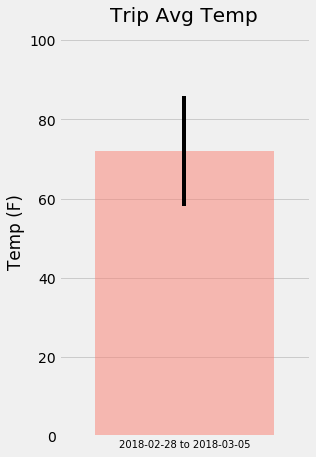

In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(4,7))
plt.bar(1,my_avg_temp,width=.5,yerr=[my_high_temp-my_low_temp],color='salmon',alpha=0.5)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.xticks([])
plt.xlabel('2018-02-28 to 2018-03-05',fontsize=10)
plt.margins(.2)
plt.yticks(np.arange(0,120,20))
plt.savefig('Images/tripAvgTemp.png')
plt.show()


In [31]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
my_first_date = '2017-02-28'
my_last_date = '2017-03-05'
total_rain = session.query(Measurement.station,func.sum(Measurement.prcp)).filter(Measurement.date >= my_first_date).filter(Measurement.date <= my_last_date).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

total_rain_all = session.query(Measurement.station,Station.name,Station.latitude,Station.longitude,Station.elevation, func.sum(Measurement.prcp))\
                  .filter(Measurement.date >= my_first_date)\
                  .filter(Measurement.date <= my_last_date)\
                  .filter(Measurement.station == Station.station)\
                  .group_by(Measurement.station)\
                  .order_by(func.sum(Measurement.prcp).desc())\
                  .all()

total_rain_df = pd.DataFrame(total_rain_all, columns=['Station','Name','Lat','Lon','Elevation','Total Amount of Rainfall'])
total_rain_df

,Station,Name,Lat,Lon,Elevation,Total Amount of Rainfall
0,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,4.72
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,4.45
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,4.07
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,2.98
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,2.74
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2.32
6,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.16


### Daily Rainfall Average

In [32]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [33]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip: my_first_date and my_last_date
trip_start = pd.to_datetime(my_first_date)
trip_end = pd.to_datetime(my_last_date)

actual_start = trip_start + dt.timedelta(days=365)
actual_end = trip_end + dt.timedelta(days=365)

# Use the start and end date to create a range of dates
# Calculate the number of dates between start and end date of trip, add one to include last date in range 
trip_period = (trip_end-trip_start).days + 1
trip_range = pd.Series(pd.date_range(my_first_date,periods=trip_period,freq='D'))
actual_period = (actual_end-actual_start).days + 1
actual_range = pd.Series(pd.date_range(actual_start.strftime('%Y-%m-%d'),periods=actual_period,freq='D'))

# Stip off the year and save a list of %m-%d strings
day_list = []
for trip in trip_range:
    day_list.append(trip.strftime('%m-%d'))
# Loop through the list of %m-%d strings and calculate the normals for each date
for day in day_list:
    normals.append(daily_normals(day))
print(f'The complete list of normals for my trip from {day_list[0]} to {day_list[len(day_list)-1]}:')
normals

The complete list of normals for my trip from 02-28 to 03-05:


[[(65.0, 70.65517241379311, 80.0)],
 [(64.0, 70.0327868852459, 76.0)],
 [(61.0, 70.36666666666666, 78.0)],
 [(60.0, 70.06896551724138, 78.0)],
 [(57.0, 69.27272727272727, 77.0)],
 [(60.0, 67.89090909090909, 76.0)]]

In [34]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
test_df = pd.DataFrame(list(zip(actual_range,normals)),columns=['Date','Normals'])
normals_test = test_df['Normals'].apply(pd.Series)
normals_test = normals_test[0].apply(pd.Series)
normals_test = normals_test.rename(columns={0:'tmin',1:'tavg',2:'tmax'})

normals_df = pd.concat([test_df[:], normals_test[:]], axis=1)
normals_df = normals_df.drop(columns='Normals')
normals_df = normals_df.set_index('Date')
normals_df

,tmin,tavg,tmax
Date,,,
2018-02-28,65.0,70.655172,80.0
2018-03-01,64.0,70.032787,76.0
2018-03-02,61.0,70.366667,78.0
2018-03-03,60.0,70.068966,78.0
2018-03-04,57.0,69.272727,77.0
2018-03-05,60.0,67.890909,76.0


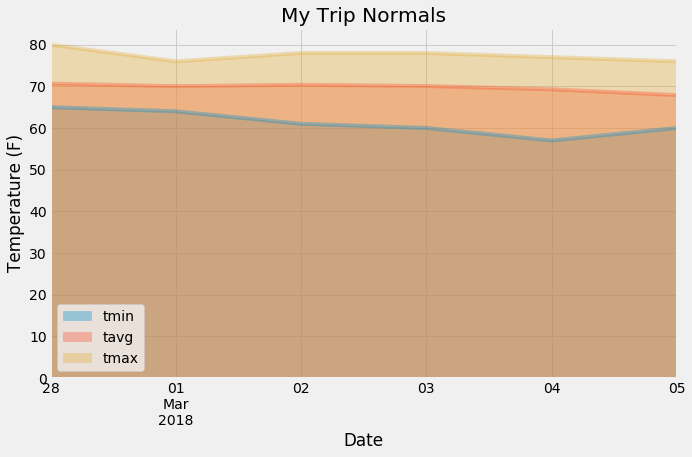

In [35]:
# Plot an area plot of my trip normals
plt.style.use('fivethirtyeight')
normals_df.plot.area(stacked=False,grid=True,alpha=0.35,figsize=(10,6))
plt.grid(b=True,which='both',axis='both')
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.title('My Trip Normals')
plt.savefig('Images/MyTripNormals.png')
plt.show()